### Importing Necessary Libraries

In [160]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.manifold import TSNE

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [3]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [4]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [5]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [6]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [7]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [8]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [9]:
fine_tune_data_resnet = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_resnet.shape

(16000, 5, 2048)

In [10]:
N_COMPS_1 = 1300 # 1600
N_COMPS_2 = 300 # 400
N_COMPS_3 = 900 # 1000
random_state = 43

In [11]:

pcas_resnet = [PCA(N_COMPS_1, random_state=random_state) for _ in range(5)]

In [12]:
for i in range(5):
    pcas_resnet[i].fit(fine_tune_data_resnet[:,i,:])

In [13]:
fine_tune_data_train_red_resnet = np.zeros((fine_tune_data_resnet.shape[0], 5, N_COMPS_1))
for i in range(5):
    fine_tune_data_train_red_resnet[:,i,:] = pcas_resnet[i].transform(fine_tune_data_resnet[:,i,:])
fine_tune_data_resnet = fine_tune_data_train_red_resnet
del fine_tune_data_train_red_resnet

In [14]:
fine_tune_data_resnet.shape

(16000, 5, 1300)

In [15]:
fine_tune_data_vgg = np.load('./Data/VGG16-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_vgg.shape

(16000, 5, 512)

In [16]:

pcas_vgg = [PCA(N_COMPS_2, random_state=random_state) for _ in range(5)]

In [17]:
for i in range(5):
    pcas_vgg[i].fit(fine_tune_data_vgg[:,i,:])

In [18]:
fine_tune_data_train_red_vgg = np.zeros((fine_tune_data_vgg.shape[0], 5, N_COMPS_2))
for i in range(5):
    fine_tune_data_train_red_vgg[:,i,:] = pcas_vgg[i].transform(fine_tune_data_vgg[:,i,:])
fine_tune_data_vgg = fine_tune_data_train_red_vgg
del fine_tune_data_train_red_vgg
fine_tune_data_vgg.shape

(16000, 5, 300)

In [19]:
fine_tune_data_inception_resnet = np.load('./Data/Inception-ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_inception_resnet.shape

(16000, 5, 1536)

In [20]:

pcas_inception_resnet = [PCA(N_COMPS_3, random_state=random_state) for _ in range(5)]

In [21]:
for i in range(5):
    pcas_inception_resnet[i].fit(fine_tune_data_inception_resnet[:,i,:])

In [22]:
fine_tune_data_train_red_inception_resnet = np.zeros((fine_tune_data_inception_resnet.shape[0], 5, N_COMPS_3))
for i in range(5):
    fine_tune_data_train_red_inception_resnet[:,i,:] = pcas_inception_resnet[i].transform(fine_tune_data_inception_resnet[:,i,:])
fine_tune_data_inception_resnet = fine_tune_data_train_red_inception_resnet
del fine_tune_data_train_red_inception_resnet
fine_tune_data_inception_resnet.shape

(16000, 5, 900)

In [23]:
fine_tune_data = np.concatenate([fine_tune_data_resnet, fine_tune_data_vgg, fine_tune_data_inception_resnet], axis=-1)
fine_tune_data.shape

(16000, 5, 2500)

In [24]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [25]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 2500)

In [26]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [27]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 2500)

In [28]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

Loading the CNN based trained model and generating data for XGBoost

In [29]:
def ftmodel():
    inputs = Input(shape=(5, N_COMPS_1 + N_COMPS_2 + N_COMPS_3))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    # x = Dense(256, name='top_dense_3', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(top_dropout_rate, name='top_dropout_4')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='RestNet-VGG-Inception-ResNet-FineTune')
    return model1

In [30]:
model1 = ftmodel()
model1.summary()

Metal device set to: Apple M1 Max
Model: "RestNet-VGG-Inception-ResNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 2500)]         0         
                                                                 
 flatten (Flatten)           (None, 12500)             0         
                                                                 
 batch_normalization (BatchN  (None, 12500)            50000     
 ormalization)                                                   
                                                                 
 top_dropout_2 (Dropout)     (None, 12500)             0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               6400512   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048  

2022-10-10 04:42:02.247824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-10 04:42:02.247942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [32]:
model1.load_weights('./Models/ResNet-VGG-Inception-ResNet-4P/auto-ResNet-VGG-Inception-ResNet-FT-model-weight')

In [33]:
model1.get_layer(index=len(model1.layers)-3).output

<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'batch_normalization_1')>

In [34]:
model2 = tf.keras.Model(model1.input, model1.get_layer(index=len(model1.layers)-3).output)

In [35]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 2500)]         0         
                                                                 
 flatten (Flatten)           (None, 12500)             0         
                                                                 
 batch_normalization (BatchN  (None, 12500)            50000     
 ormalization)                                                   
                                                                 
 top_dropout_2 (Dropout)     (None, 12500)             0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               6400512   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                             

In [61]:
data_train = model2.predict(fine_tune_data_train)
data_train.shape

475/475 [==============================] - 1s 1ms/step


(15200, 512)

In [62]:
data_test = model2.predict(fine_tune_data_test)
data_test.shape

25/25 [==============================] - 0s 2ms/step


(800, 512)

In [50]:
data_viz = model2.predict(fine_tune_data)
data_viz.shape

500/500 [==============================] - 1s 1ms/step


(16000, 512)

## T-SNE

In [48]:
tsne = TSNE(n_components=2, learning_rate="auto", random_state=43, init="random")
tsne_embd = tsne.fit_transform(data_viz)

In [49]:
labs = labels['label'].to_numpy()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray', 'cornflowerblue', 'burlywood', 'magenta', 'indigo']

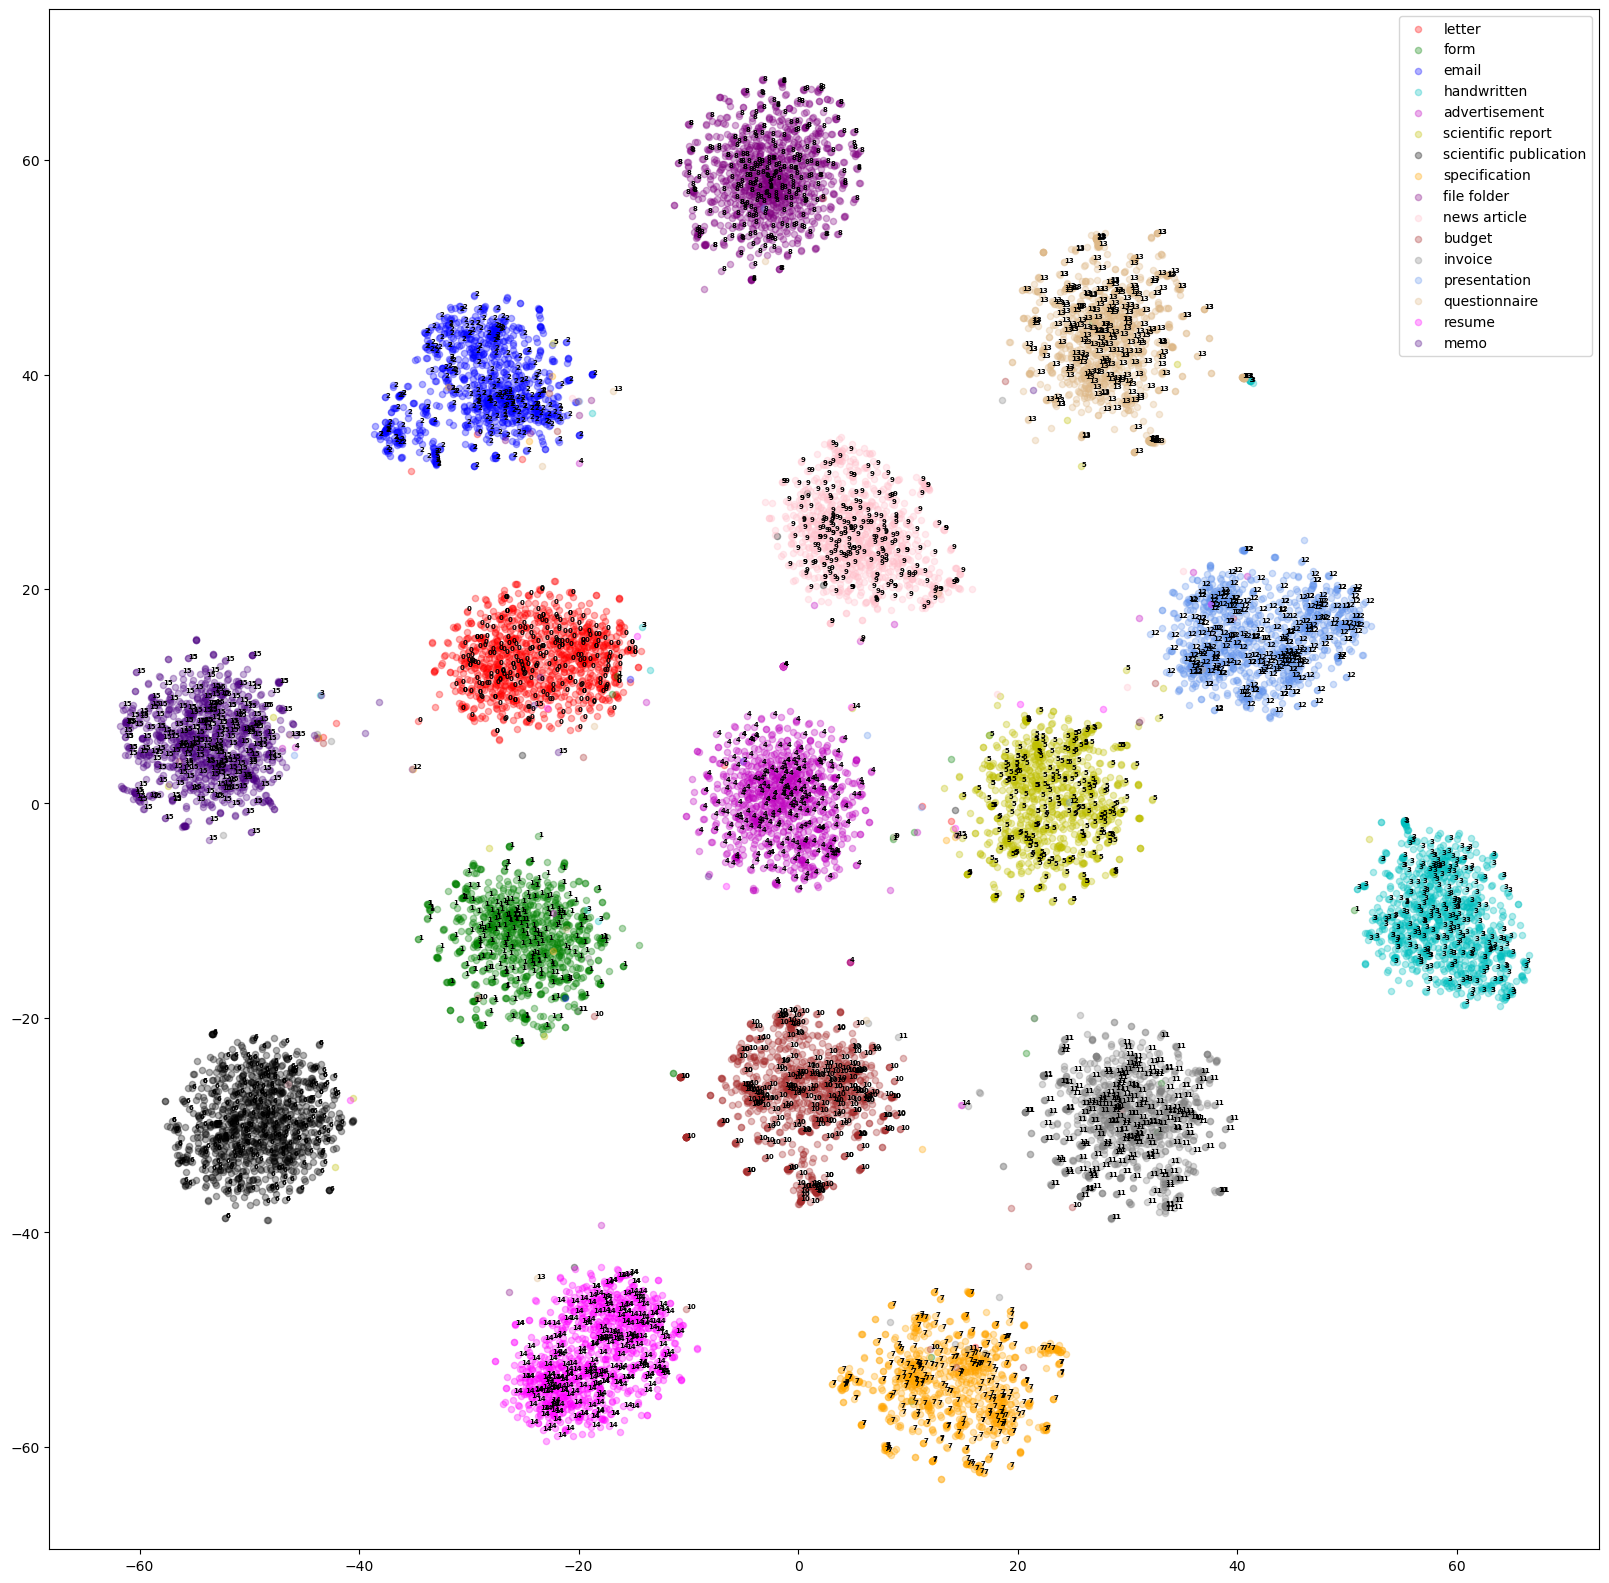

In [50]:
plt.figure(figsize=(20, 20))
for lab, col in zip(class_labels, colors):
    plt.scatter(tsne_embd[labs==lab,0], tsne_embd[labs==lab,1], s=20, c=col, alpha=0.3, label=class_names[lab])
    
    rand = np.random.choice(np.sum(labs==lab), np.sum(labs==lab)//4)
    for pt in rand:
        plt.annotate(lab, (tsne_embd[labs==lab,0][pt], tsne_embd[labs==lab,1][pt]), size=5, weight='bold', color='k')   
plt.legend()
plt.show()

The above interesting plot and clear clusters make me think if we observe this behavior in the validation set as well.


### Validation Set

In [36]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [37]:
fine_tune_data_validation_resnet = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_resnet.shape

(900, 5, 2048)

In [38]:
fine_tune_data_validation_vgg = np.load('./Data/VGG16-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_vgg.shape

(900, 5, 512)

In [39]:
fine_tune_data_validation_inception_resnet = np.load('./Data/Inception-ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_inception_resnet.shape

(900, 5, 1536)

In [40]:
fine_tune_data_validation_red_resnet = np.zeros((fine_tune_data_validation_resnet.shape[0], 5, N_COMPS_1))
for i in range(5):
    fine_tune_data_validation_red_resnet[:,i,:] = pcas_resnet[i].transform(fine_tune_data_validation_resnet[:,i,:])
fine_tune_data_validation_resnet = fine_tune_data_validation_red_resnet
del fine_tune_data_validation_red_resnet
fine_tune_data_validation_resnet.shape

(900, 5, 1300)

In [41]:
fine_tune_data_validation_red_vgg = np.zeros((fine_tune_data_validation_vgg.shape[0], 5, N_COMPS_2))
for i in range(5):
    fine_tune_data_validation_red_vgg[:,i,:] = pcas_vgg[i].transform(fine_tune_data_validation_vgg[:,i,:])
fine_tune_data_validation_vgg = fine_tune_data_validation_red_vgg
del fine_tune_data_validation_red_vgg
fine_tune_data_validation_vgg.shape

(900, 5, 300)

In [42]:
fine_tune_data_validation_red_inception_resnet = np.zeros((fine_tune_data_validation_inception_resnet.shape[0], 5, N_COMPS_3))
for i in range(5):
    fine_tune_data_validation_red_inception_resnet[:,i,:] = pcas_inception_resnet[i].transform(fine_tune_data_validation_inception_resnet[:,i,:])
fine_tune_data_validation_inception_resnet = fine_tune_data_validation_red_inception_resnet
del fine_tune_data_validation_red_inception_resnet
fine_tune_data_validation_inception_resnet.shape

(900, 5, 900)

In [43]:
fine_tune_data_validation = np.concatenate([fine_tune_data_validation_resnet, fine_tune_data_validation_vgg, fine_tune_data_validation_inception_resnet], axis=-1)
fine_tune_data_validation.shape

(900, 5, 2500)

In [44]:
valid_viz = model2.predict(fine_tune_data_validation)
valid_viz.shape

29/29 [==============================] - 0s 2ms/step


2022-10-10 04:42:42.882137: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-10 04:42:42.922055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(900, 512)

### Visualization

In [45]:
tsne = TSNE(n_components=2, learning_rate="auto", random_state=43, init="random")
tsne_embd = tsne.fit_transform(valid_viz)

In [46]:
labs = labels['label'].to_numpy()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray', 'cornflowerblue', 'burlywood', 'magenta', 'indigo']

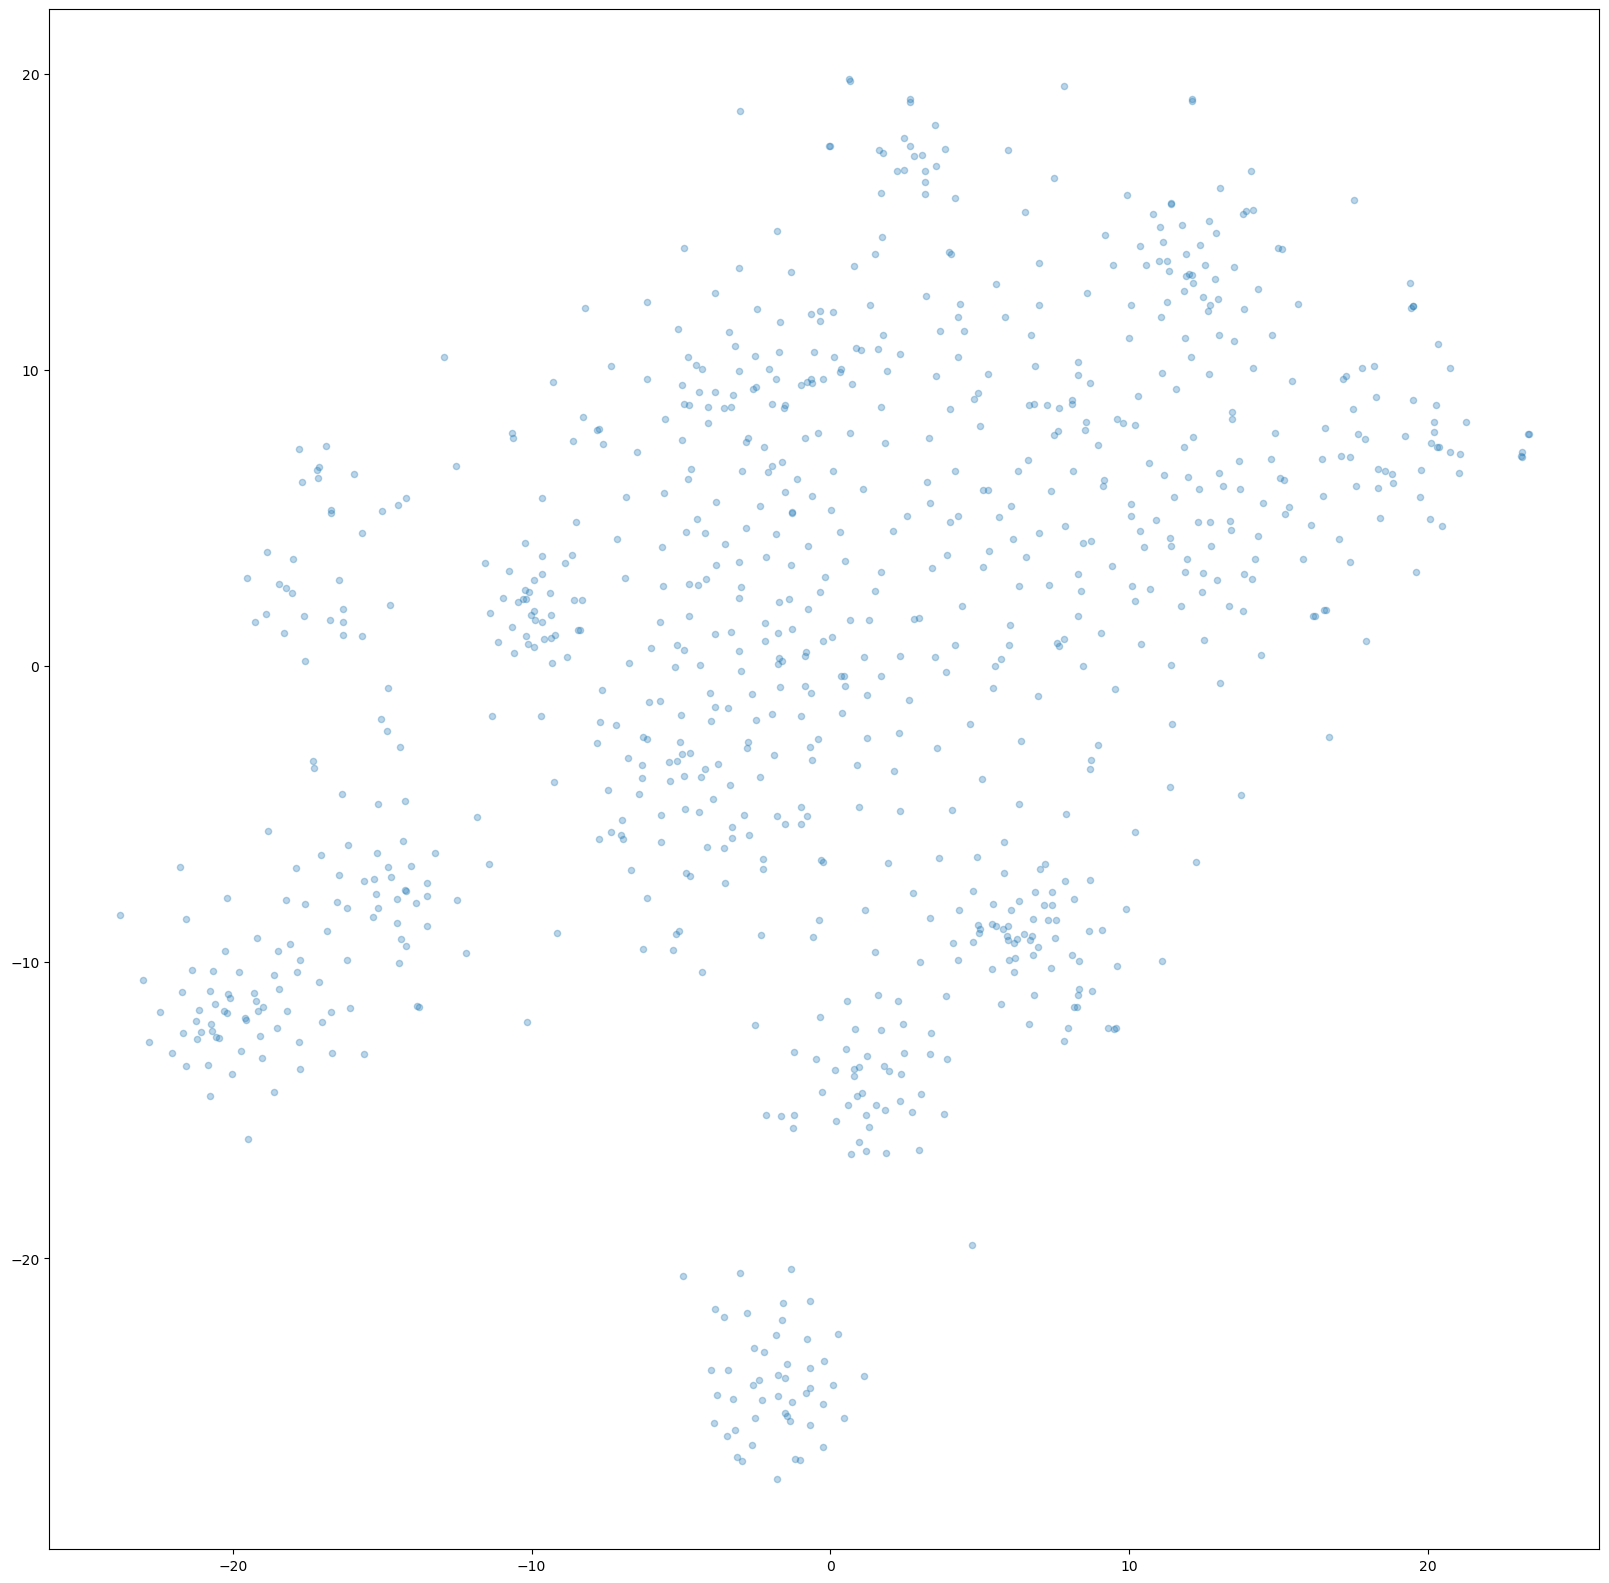

In [48]:
plt.figure(figsize=(20, 20))
plt.scatter(tsne_embd[:,0], tsne_embd[:,1], s=20, alpha=0.3)
plt.show()

### Train + Validation

In [51]:
full_viz = np.concatenate([data_viz, valid_viz])
full_viz.shape

(16900, 512)

In [52]:
tsne = TSNE(n_components=2, learning_rate="auto", random_state=43, init="random")
tsne_embd = tsne.fit_transform(full_viz)

In [53]:
labs = labels['label'].to_numpy()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray', 'cornflowerblue', 'burlywood', 'magenta', 'indigo']

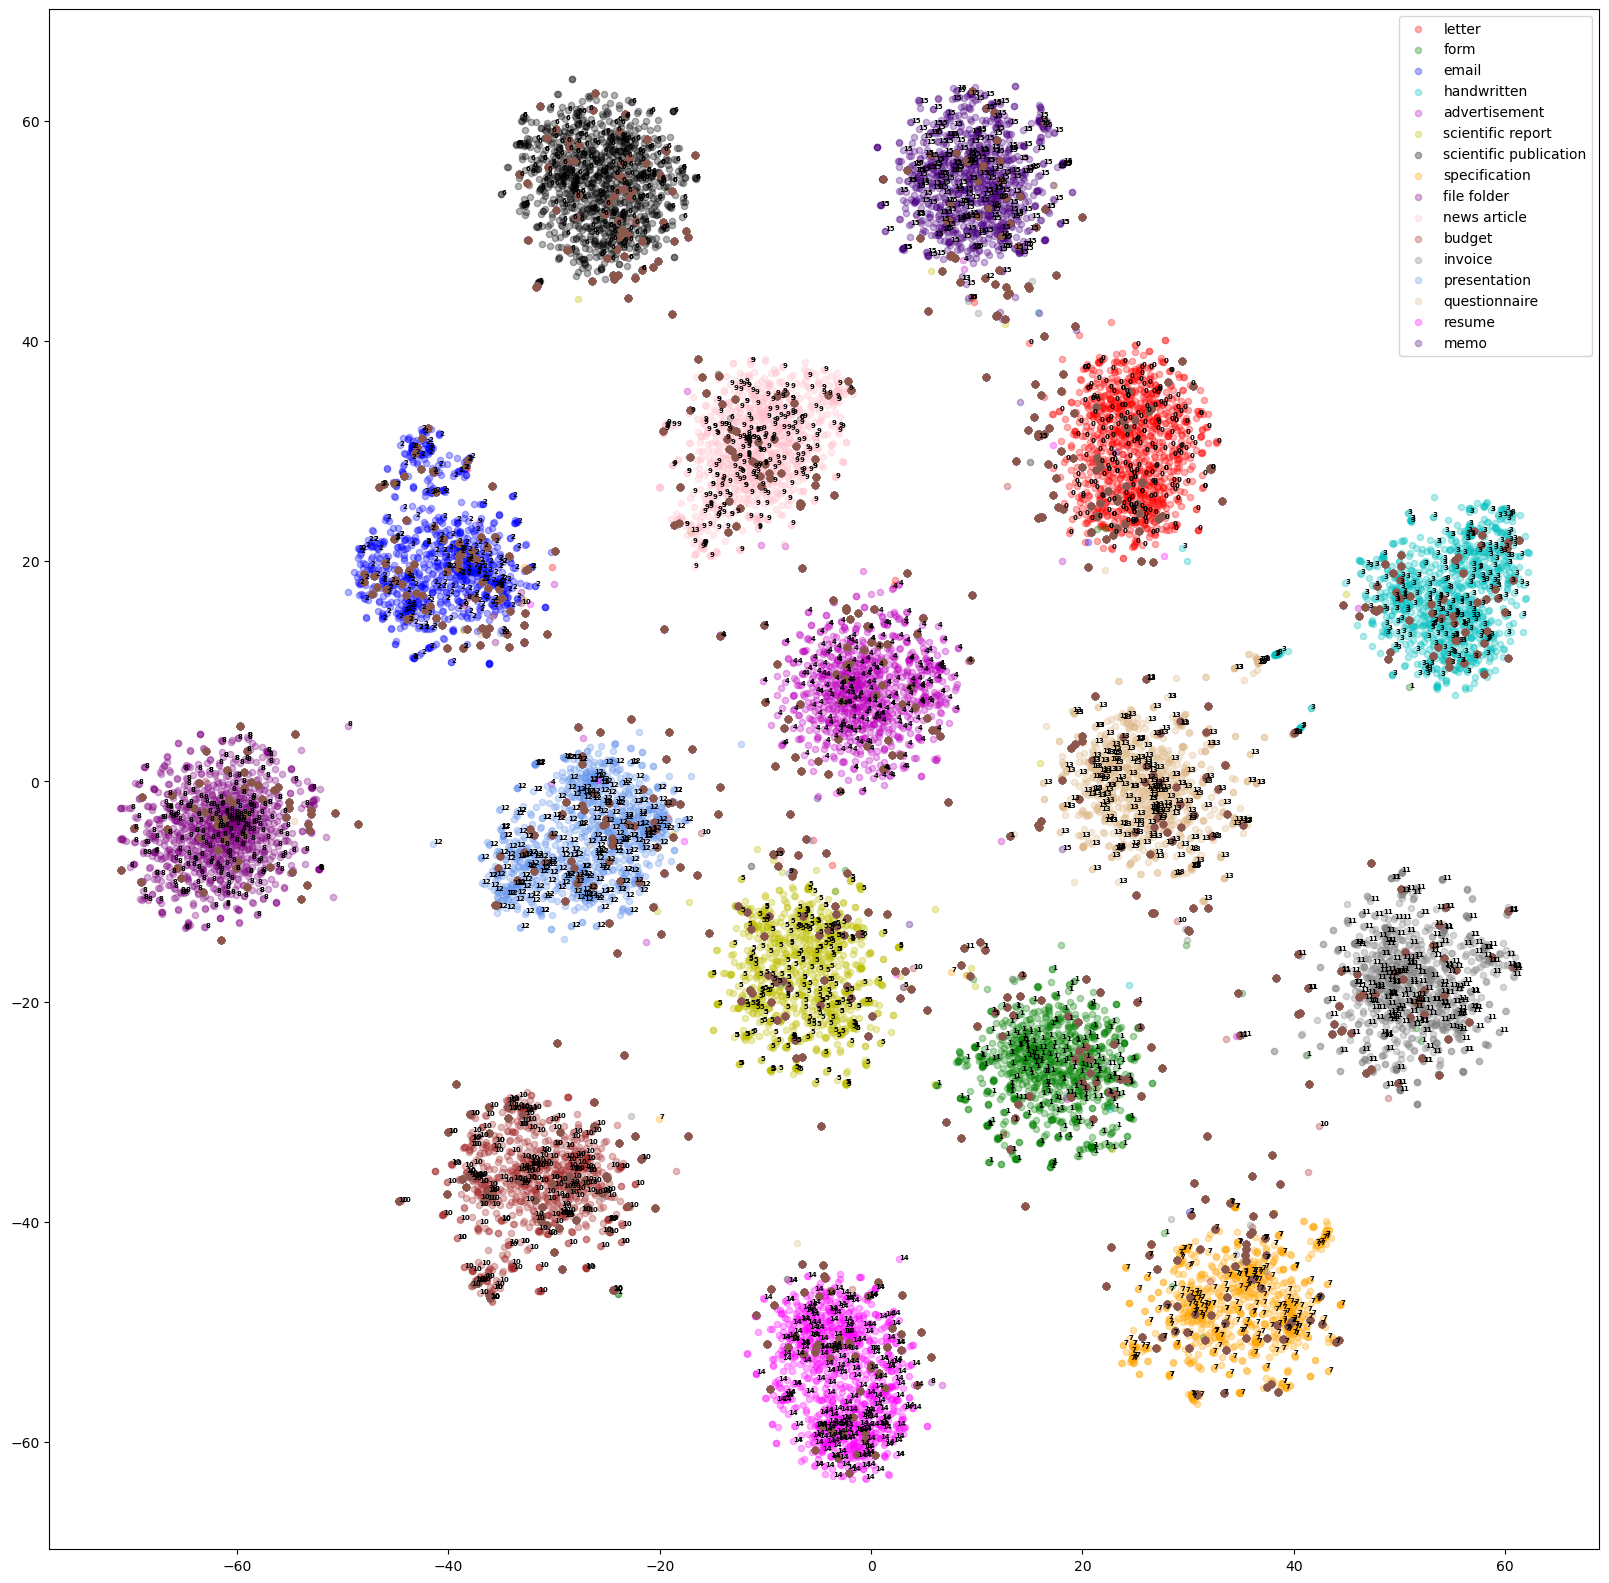

In [55]:
plt.figure(figsize=(20, 20))
for lab, col in zip(class_labels, colors):
    plt.scatter(tsne_embd[:16000,:][labs==lab,0], tsne_embd[:16000,:][labs==lab,1], s=20, c=col, alpha=0.3, label=class_names[lab])
    plt.scatter(tsne_embd[16000:,0], tsne_embd[16000:,1], s=20)
    rand = np.random.choice(np.sum(labs==lab), np.sum(labs==lab)//4)
    for pt in rand:
        plt.annotate(lab, (tsne_embd[:16000,:][labs==lab,0][pt], tsne_embd[:16000,:][labs==lab,1][pt]), size=5, weight='bold', color='k')  
        
    plt.annotate
plt.legend()
plt.show()

This above plot looks oddly good clustering even in the validation set. Let's try exploiting that.

## Clustering-Type Models

### KNN

In [64]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(data_train, fine_tune_labels_train)

KNeighborsClassifier(n_neighbors=10)

#### Training Data

In [65]:
neigh.score(data_train, fine_tune_labels_train)

0.9988157894736842

In [67]:
train_pred_labels = neigh.predict(data_train)

In [68]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [69]:
np.sum(train_pred_labels == train_labels['label'])

15182

In [70]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
569,598,./Data/train/train/598.tif,4
2959,3112,./Data/train/train/3112.tif,4
5500,5789,./Data/train/train/5789.tif,9
5618,5912,./Data/train/train/5912.tif,0
6208,6535,./Data/train/train/6535.tif,5
7099,7464,./Data/train/train/7464.tif,4
8568,9024,./Data/train/train/9024.tif,10
9198,9682,./Data/train/train/9682.tif,12
9898,10423,./Data/train/train/10423.tif,10
10030,10567,./Data/train/train/10567.tif,1


In [71]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.996936,0.997955,0.997445,978
1,1.000000,0.997838,0.998918,925
2,0.991426,1.000000,0.995694,925
3,1.000000,1.000000,1.000000,947
4,0.998918,0.992473,0.995685,930
5,1.000000,0.998960,0.999480,962
6,0.998999,1.000000,0.999499,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.997901,0.998950,953


#### On Train-Test Data

In [73]:
test_pred_labels = neigh.predict(data_test)

In [74]:
test_pred_labels

array([11,  8,  0,  7,  2,  6, 13,  2, 14,  1,  6,  0,  7, 14,  1, 11,  0,
        9,  6, 10,  2, 14,  3, 12,  6,  0,  3,  2,  3,  3, 15,  1,  9,  2,
        5,  8,  4,  7, 11,  9,  6, 12, 14,  2,  5, 14,  5,  0, 13,  2,  0,
       10, 12,  0, 11, 14, 15,  6,  9,  2, 15, 13,  2, 11,  6, 10,  8,  0,
        6,  3,  9,  4, 12,  0,  8,  6,  7,  0, 12, 11, 11, 14, 12, 12,  9,
        2,  1, 13, 13, 13, 10, 11,  4, 10,  1,  7, 11,  8, 13, 10,  3, 10,
       12,  9,  7, 14,  8,  2,  5, 15,  7,  5,  9,  4, 12, 12, 12, 13, 11,
        6, 13,  1,  0, 12,  1,  5, 13, 12,  0, 14,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8, 13, 12,  8,  5,  8,  9,  2, 13, 15, 14,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 12, 13,  8,  2,  8,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 10, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 13, 10, 11, 11, 10, 13,  9,  1,
        9,  5, 13, 14, 12,  1, 12,  8,  7,  6, 13,  5,  4, 12,  8,  0,  9,
       13, 15,  1,  7,  5

In [75]:
np.sum(test_pred_labels == test_labels['label'])

606

In [76]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
5,67,./Data/train/train/67.tif,9
7,100,./Data/train/train/100.tif,10
...,...,...,...
779,15568,./Data/train/train/15568.tif,9
783,15589,./Data/train/train/15589.tif,5
784,15596,./Data/train/train/15596.tif,8
788,15687,./Data/train/train/15687.tif,12


In [77]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.709677,0.814815,0.758621,54
1,0.666667,0.636364,0.651163,44
2,0.554054,0.953488,0.700855,43
3,0.973684,0.804348,0.880952,46
4,1.000000,0.611111,0.758621,36
5,0.722222,0.520000,0.604651,50
6,0.816327,0.869565,0.842105,46
7,0.642857,0.865385,0.737705,52
8,0.923077,0.888889,0.905660,54
9,0.897436,0.744681,0.813953,47


In [78]:
np.mean(fscore)

0.7551951826436745

Let's repeat with the t-SNE extracted values.

In [141]:
tsne = TSNE(n_components=2, learning_rate="auto", random_state=43, init="random")
tsne_embd_full = tsne.fit_transform(full_viz)

In [142]:
tsne_embd_train = tsne_embd_full[:16000,:][list(train_labels['id'])]

In [143]:
tsne_embd_test = tsne_embd_full[:16000,:][list(test_labels['id'])]

In [144]:
tsne_embd_validation = tsne_embd_full[16000:,:]

In [199]:
neigh_tsne = KNeighborsClassifier(n_neighbors=4)
neigh_tsne.fit(tsne_embd_train, fine_tune_labels_train)

KNeighborsClassifier(n_neighbors=4)

In [200]:
neigh_tsne.score(tsne_embd_train, fine_tune_labels_train)

0.9992105263157894

In [201]:
train_pred_labels = neigh_tsne.predict(tsne_embd_train)

In [202]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [203]:
np.sum(train_pred_labels == train_labels['label'])

15188

In [204]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
43,47,./Data/train/train/47.tif,1
263,280,./Data/train/train/280.tif,10
3049,3203,./Data/train/train/3203.tif,4
4223,4443,./Data/train/train/4443.tif,5
5500,5789,./Data/train/train/5789.tif,9
5618,5912,./Data/train/train/5912.tif,0
6201,6528,./Data/train/train/6528.tif,4
9198,9682,./Data/train/train/9682.tif,12
10775,11351,./Data/train/train/11351.tif,5
12255,12896,./Data/train/train/12896.tif,9


In [205]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.997957,0.998978,0.998467,978
1,0.996764,0.998919,0.997840,925
2,0.997843,1.000000,0.998920,925
3,1.000000,1.000000,1.000000,947
4,0.997849,0.997849,0.997849,930
5,1.000000,0.996881,0.998438,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,0.998950,0.997901,0.998425,953


In [206]:
test_pred_labels = neigh_tsne.predict(tsne_embd_test)

In [207]:
np.sum(test_pred_labels == test_labels['label'])

639

In [208]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
7,100,./Data/train/train/100.tif,10
11,164,./Data/train/train/164.tif,15
...,...,...,...
779,15568,./Data/train/train/15568.tif,9
784,15596,./Data/train/train/15596.tif,8
787,15668,./Data/train/train/15668.tif,11
788,15687,./Data/train/train/15687.tif,12


In [209]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.741379,0.796296,0.767857,54
1,0.644444,0.659091,0.651685,44
2,0.694915,0.953488,0.803922,43
3,0.928571,0.847826,0.886364,46
4,0.800000,0.666667,0.727273,36
5,0.705882,0.720000,0.712871,50
6,0.951220,0.847826,0.896552,46
7,0.762712,0.865385,0.810811,52
8,0.942308,0.907407,0.924528,54
9,0.866667,0.829787,0.847826,47


In [210]:
np.mean(fscore)

0.794988619893606

### SVM

In [220]:
clf = make_pipeline(StandardScaler(), SVC(decision_function_shape='ovo'))

In [221]:
clf.fit(data_train, fine_tune_labels_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(decision_function_shape='ovo'))])

In [223]:
clf.score(data_train, fine_tune_labels_train)

0.9998026315789473

In [224]:
train_pred_labels = clf.predict(data_train)

In [225]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [226]:
np.sum(train_pred_labels == train_labels['label'])

15197

In [227]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [228]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


In [229]:
test_pred_labels = clf.predict(data_test)

In [230]:
np.sum(test_pred_labels == test_labels['label'])

655

In [231]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
2,33,./Data/train/train/33.tif,6
4,65,./Data/train/train/65.tif,14
7,100,./Data/train/train/100.tif,10
11,164,./Data/train/train/164.tif,15
19,372,./Data/train/train/372.tif,13
...,...,...,...
769,15453,./Data/train/train/15453.tif,14
776,15528,./Data/train/train/15528.tif,5
779,15568,./Data/train/train/15568.tif,9
783,15589,./Data/train/train/15589.tif,5


In [232]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.807018,0.851852,0.828829,54
1,0.666667,0.727273,0.695652,44
2,0.951220,0.906977,0.928571,43
3,0.955556,0.934783,0.945055,46
4,0.864865,0.888889,0.876712,36
5,0.653061,0.640000,0.646465,50
6,0.886364,0.847826,0.866667,46
7,0.860000,0.826923,0.843137,52
8,0.877193,0.925926,0.900901,54
9,0.808511,0.808511,0.808511,47


In [233]:
np.mean(fscore)

0.8199971680018614

In [234]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [235]:
valid_pred_labels = clf.predict(valid_viz)

### Submission

In [236]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,4


In [237]:
submission_data.to_csv('./Submissions/submission-resnet-vgg-inception-4p-PCA-SVM.csv', index=False)